# Dynamical System: Lorenz-63


In [1]:
import autoroot  # noqa: F401, I001
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import diffrax as dfx
import xarray as xr

from jaxsw._src.models.lorenz63 import L63State, Lorenz63, rhs_lorenz_63

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Lorenz 63

* Equation of Motion
* Observation Operator
* Integrate

### Equation of Motion

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma (y - x) \\
\frac{dy}{dt} &= x (\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{aligned}
$$

where $(\sigma,\rho,\beta)$ are hyperparameters.

In [2]:
s, r, b = 10, 28, 2.667

In [3]:
# initialize state
state, params = L63State.init_state(noise=0.01, s=10, r=28, b=2.667)

# rhs
x, y, z = state.x, state.y, state.z
s, r, b = params.s, params.r, params.b

state_dot = rhs_lorenz_63(x=x, y=y, z=z, s=s, r=r, b=b)

x_dot, y_dot, z_dot = state_dot

assert x.shape == y.shape == z.shape == x_dot.shape
assert x_dot.shape == y_dot.shape == z_dot.shape == x.shape

### Model

In [4]:
# initialize state
state_init, params = L63State.init_state(noise=0.01, s=10, r=28, b=2.667)

# initialize model
l63_model = Lorenz63()

# step through
state_dot = l63_model.equation_of_motion(t=0, state=state_init, args=params)

state_dot

L63State(x=Array(0.07530808, dtype=float32), y=Array(25.796667, dtype=float32), z=Array(-1.6745309, dtype=float32))

## Time Stepping

In [5]:
dt = 0.01
t0 = 0.0
t1 = 30.0
# observe_every = 10
ts = jnp.arange(t0, t1, dt)

saveat = dfx.SaveAt(t0=t0, t1=t1, ts=ts)
saveat

SaveAt(
  subs=SubSaveAt(
    t0=0.0,
    t1=30.0,
    ts=f32[3000],
    steps=False,
    fn=<function save_y>
  ),
  dense=False,
  solver_state=False,
  controller_state=False,
  made_jump=False
)

In [6]:
# Euler, Constant StepSize
solver = dfx.Euler()
stepsize_controller = dfx.ConstantStepSize()

# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(l63_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=params,
    stepsize_controller=stepsize_controller,
)

In [7]:
sol.ys.x.shape

(3001,)

In [8]:
da_sol = xr.DataArray(
    data=np.stack([sol.ys.x, sol.ys.y, sol.ys.z], axis=1),
    dims=["time", "component"],
    coords={
        "component": (["component"], ["x", "y", "z"]),
        "time": (["time"], np.asarray(sol.ts)),
    },
    attrs={"ode": "lorenz_63", "s": params.s, "b": params.b, "r": params.r},
)

da_sol

<xarray.DataArray (time: 3001, component: 3)>
array([[  0.9924692,   1.       ,   1.       ],
       [  0.9932223,   1.2579666,   0.9832547],
       [  1.0196967,   1.5137233,   0.9695257],
       ...,
       [-11.882383 , -11.912851 ,  31.399418 ],
       [-11.88543  , -11.389761 ,  31.977528 ],
       [-11.88543  , -11.389761 ,  31.977528 ]], dtype=float32)
Coordinates:
  * component  (component) <U1 'x' 'y' 'z'
  * time       (time) float32 0.0 0.01 0.02 0.03 ... 29.97 29.98 29.99 29.99
Attributes:
    ode:      lorenz_63
    s:        10
    b:        2.667
    r:        28

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


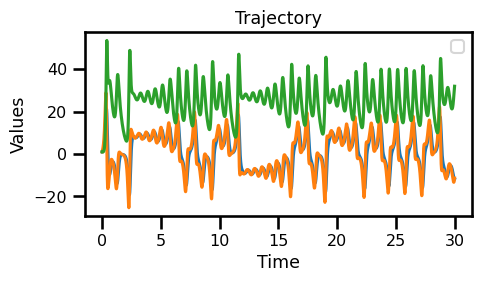

In [9]:
fig, ax = plt.subplots(figsize=(5, 3))

da_sol.sel(component="x").plot(ax=ax)
da_sol.sel(component="y").plot(ax=ax)
da_sol.sel(component="z").plot(ax=ax)

ax.set_xlabel("Time")
ax.set_ylabel("Values")
ax.set_title("Trajectory")

plt.legend()
plt.tight_layout()
plt.show()

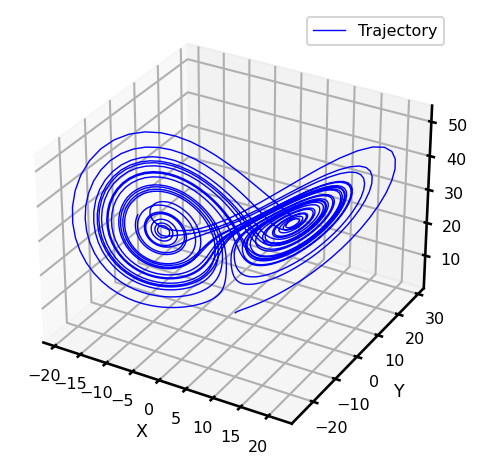

In [10]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot(
    da_sol.sel(component="x"),
    da_sol.sel(component="y"),
    da_sol.sel(component="z"),
    lw=1.0,
    color="blue",
    label="Trajectory",
)
# ax.scatter3D(out.x[::10], out.y[::10], out.z[::10], lw=0.5, color="red", label="y")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.legend()
plt.tight_layout()
plt.show()

## Generating Observations


In [11]:
ds_sol = da_sol.to_dataset(name="simulation")

ds_sol["observations"] = xr.full_like(ds_sol.simulation, np.nan)

ds_sol

<xarray.Dataset>
Dimensions:       (component: 3, time: 3001)
Coordinates:
  * component     (component) <U1 'x' 'y' 'z'
  * time          (time) float32 0.0 0.01 0.02 0.03 ... 29.97 29.98 29.99 29.99
Data variables:
    simulation    (time, component) float32 0.9925 1.0 1.0 ... -11.39 31.98
    observations  (time, component) float32 nan nan nan nan ... nan nan nan nan

### Missing Time

In [12]:
sample_step = 20
ds_sol["observations"] = xr.full_like(ds_sol.simulation, np.nan)
ds_sol["observations"].loc[::sample_step] = ds_sol["simulation"].loc[::sample_step]

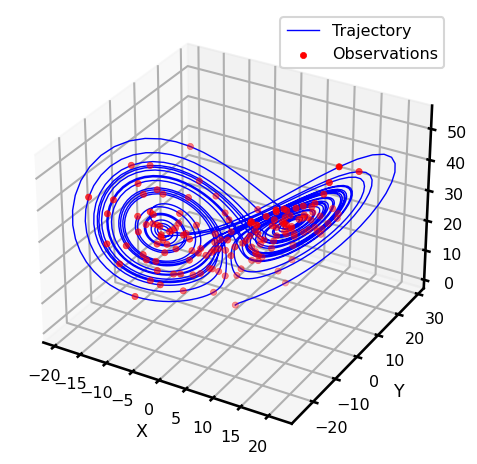

In [13]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot(
    ds_sol.simulation.sel(component="x"),
    ds_sol.simulation.sel(component="y"),
    ds_sol.simulation.sel(component="z"),
    lw=1.0,
    color="blue",
    label="Trajectory",
)
ax.scatter3D(
    ds_sol.observations.sel(component="x"),
    ds_sol.observations.sel(component="y"),
    ds_sol.observations.sel(component="z"),
    lw=0.5,
    color="red",
    label="Observations",
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.legend()
plt.tight_layout()
plt.show()

### Adding Noise

In [14]:
# def add_noise(da, sigma=2**.5):
#     return da  + np.random.randn(*da.shape) * sigma

sigma = 2**0.5

ds_sol["observations"] += sigma * np.random.randn(*ds_sol["observations"].shape)

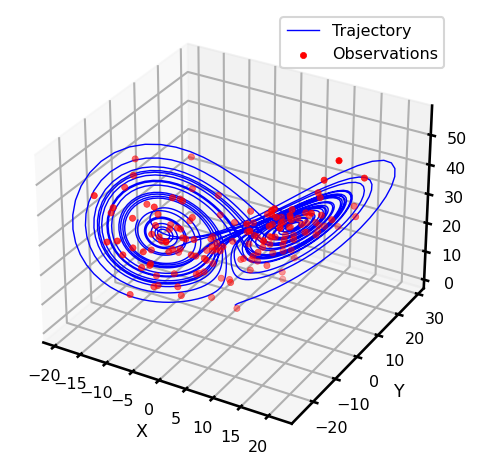

In [15]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot(
    ds_sol.simulation.sel(component="x"),
    ds_sol.simulation.sel(component="y"),
    ds_sol.simulation.sel(component="z"),
    lw=1.0,
    color="blue",
    label="Trajectory",
)
ax.scatter3D(
    ds_sol.observations.sel(component="x"),
    ds_sol.observations.sel(component="y"),
    ds_sol.observations.sel(component="z"),
    lw=0.5,
    color="red",
    label="Observations",
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
da_sol

<xarray.DataArray (time: 3001, component: 3)>
array([[  0.9924692,   1.       ,   1.       ],
       [  0.9932223,   1.2579666,   0.9832547],
       [  1.0196967,   1.5137233,   0.9695257],
       ...,
       [-11.882383 , -11.912851 ,  31.399418 ],
       [-11.88543  , -11.389761 ,  31.977528 ],
       [-11.88543  , -11.389761 ,  31.977528 ]], dtype=float32)
Coordinates:
  * component  (component) <U1 'x' 'y' 'z'
  * time       (time) float32 0.0 0.01 0.02 0.03 ... 29.97 29.98 29.99 29.99
Attributes:
    ode:      lorenz_63
    s:        10
    b:        2.667
    r:        28

## Batch of Observations

In [17]:
batchsize = 100

state_batch, params = L63State.init_state_batch(
    batchsize=batchsize, noise=0.01, s=s, r=r, b=b
)

fn_batched = jax.vmap(rhs_lorenz_63, in_axes=(0, 0, 0, None, None, None))

state_dot_batch = fn_batched(state_batch.x, state_batch.y, state_batch.z, s, r, b)
x_dot, y_dot, z_dot = state_dot_batch
# state_dot_batch = fn_batched(state_batch)

assert x_dot.shape == y_dot.shape == z_dot.shape == state_batch.x.shape
assert state_batch.x.shape == state_batch.y.shape == state_batch.z.shape == x_dot.shape

In [18]:
# Euler, Constant StepSize
solver = dfx.Euler()
stepsize_controller = dfx.ConstantStepSize()

# integration
integrate = lambda state: dfx.diffeqsolve(
    terms=dfx.ODETerm(l63_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state,
    saveat=saveat,
    args=params,
    stepsize_controller=stepsize_controller,
)
sol = jax.vmap(integrate)(state_batch)

In [19]:
sol.ys.x.shape, len(np.arange(0, len(sol.ys.x))), np.stack(
    [sol.ys.x, sol.ys.y, sol.ys.z], axis=2
).squeeze().shape

((100, 3001, 1), 100, (100, 3001, 3))

In [20]:
da_sol = xr.DataArray(
    data=np.stack([sol.ys.x, sol.ys.y, sol.ys.z], axis=2).squeeze(),
    dims=["realization", "time", "component"],
    coords={
        "realization": (["realization"], np.arange(0, len(sol.ys.x))),
        "component": (["component"], ["x", "y", "z"]),
        "time": (["time"], np.asarray(sol.ts[0])),
    },
    attrs={"ode": "lorenz_63", "s": params.s, "b": params.b, "r": params.r},
)

da_sol

<xarray.DataArray (realization: 100, time: 3001, component: 3)>
array([[[  1.0009104 ,   1.        ,   1.        ],
        [  1.0008193 ,   1.2602458 ,   0.98333913],
        [  1.026762  ,   1.5180314 ,   0.96972626],
        ...,
        [  7.841297  ,   7.554106  ,  26.608688  ],
        [  7.8125772 ,   7.5876603 ,  26.491373  ],
        [  7.8125772 ,   7.5876603 ,  26.491373  ]],

       [[  0.9915768 ,   1.        ,   1.        ],
        [  0.9924191 ,   1.2577257 ,   0.9832458 ],
        [  1.0189497 ,   1.5132679 ,   0.96950454],
        ...,
        [ -5.028643  ,  -7.1996446 ,  22.83716   ],
        [ -5.2457485 ,  -7.387307  ,  22.590153  ],
        [ -5.2457485 ,  -7.387307  ,  22.590153  ]],

       [[  1.0089169 ,   1.        ,   1.        ],
        [  1.0080252 ,   1.2624075 ,   0.9834192 ],
        [  1.0334634 ,   1.5221174 ,   0.96991676],
        ...,
...
        ...,
        [  9.369921  ,  13.830775  ,  21.305256  ],
        [  9.816016  ,  14.319613  ,  22.033121  ],
        [  9.816016  ,  14.319613  ,  22.033121  ]],

       [[  1.0030307 ,   1.        ,   1.        ],
        [  1.0027276 ,   1.2608182 ,   0.9833603 ],
        [  1.0285367 ,   1.5191134 ,   0.96977663],
        ...,
        [-14.774796  , -18.045319  ,  32.183964  ],
        [-15.101855  , -17.246246  ,  33.991695  ],
        [-15.101855  , -17.246246  ,  33.991695  ]],

       [[  0.9984074 ,   1.        ,   1.        ],
        [  0.9985667 ,   1.25957   ,   0.9833141 ],
        [  1.024667  ,   1.5167539 ,   0.9696668 ],
        ...,
        [  2.3623636 ,  -0.43535534,  25.198727  ],
        [  2.0825853 ,  -0.36494714,  24.516365  ],
        [  2.0825853 ,  -0.36494714,  24.516365  ]]], dtype=float32)
Coordinates:
  * realization  (realization) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * component    (component) <U1 'x' 'y' 'z'
  * time         (time) float32 0.0 0.01 0.02 0.03 ... 29.97 29.98 29.99 29.99
Attributes:
    ode:      lorenz_63
    s:        10
    b:        2.667
    r:        28

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


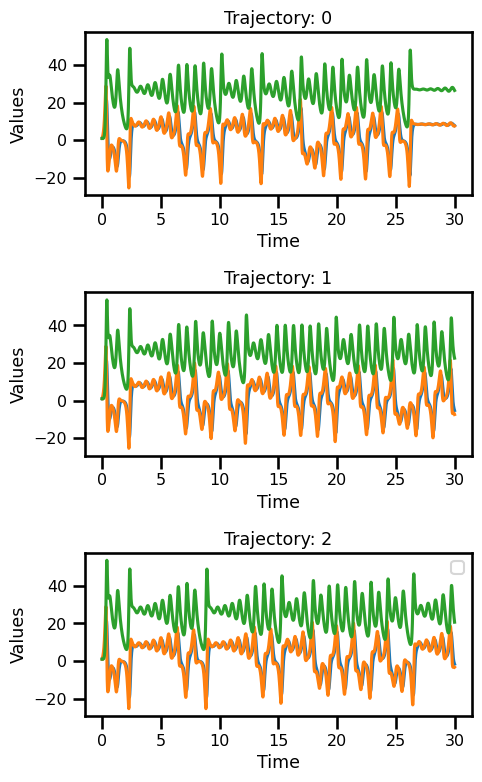

In [21]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))

for i in range(3):
    da_sol.sel(component="x", realization=i).plot(ax=ax[i])
    da_sol.sel(component="y", realization=i).plot(ax=ax[i])
    da_sol.sel(component="z", realization=i).plot(ax=ax[i])

    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Values")
    ax[i].set_title(f"Trajectory: {i}")


plt.legend()
plt.tight_layout()
plt.show()

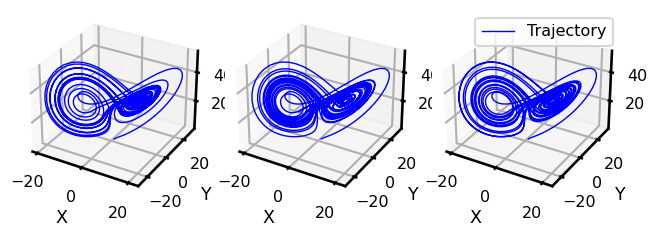

In [22]:
fig, ax = plt.subplots(ncols=3, subplot_kw={"projection": "3d"})
for i in range(3):
    ax[i].plot(
        da_sol.sel(component="x", realization=i),
        da_sol.sel(component="y", realization=i),
        da_sol.sel(component="z", realization=i),
        lw=1.0,
        color="blue",
        label="Trajectory",
    )
    ax[i].set_xlabel("X")
    ax[i].set_ylabel("Y")
    ax[i].set_zlabel("Z")
# ax.scatter3D(out.x[::10], out.y[::10], out.z[::10], lw=0.5, color="red", label="y")


plt.legend()
plt.tight_layout()
plt.show()